In [1]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

from sklearn.manifold import TSNE

In [2]:
data_dir = '2021-07-19'

# colors = ['lightcoral','palegreen','skyblue','m','chocolate','orange']

papers = pd.read_csv(f'scibert编码文章/valid_metadata_{data_dir}.csv',sep='\t').set_index('cord_uid')[['title','journal','publish_time']].sort_values('publish_time')

jrnls = Counter(papers['journal']).most_common(100)

# selected = [j[0] for j in jrnls]
selected = ['Br J Surg','Nat Commun'] # 'Int J Environ Res Public Health',
# selected = ['Int J Environ Res Public Health','Front Public Health','Br J Surg','Front Immunol','Int J Mol Sci','J Clin Med']
# selected = ['Int J Environ Res Public Health','Br J Surg','Int J Mol Sci']

n_per_class = 60
samples = []
for jrnl in selected:
    df = papers.loc[papers['journal']==jrnl].sample(n=n_per_class, random_state=0)
    samples.append(df)
samples = pd.concat(samples,axis=0)

samples['label'] = list(map(lambda x:selected.index(x),samples['journal'].tolist()))

models_embeddings = dict()
for method in ['tfidf','glove','scibert']:
    # SCIBERT Embedding
    if method == 'scibert':
        print('scibert')
        title_embs_df = pd.read_csv(f'scibert编码文章/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert编码文章/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values
        pca = TruncatedSVD(n_components=512)
        X = pca.fit_transform(X)
        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # Glove Embedding
    if method == 'glove':
        print('glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        # X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
        X = paper_emb.values
        pca = TruncatedSVD(n_components=512)
        X = pca.fit_transform(X)
        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # TF-IDF Embedding
    if method == 'tfidf':
        print('tfidf')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        # X = values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
        X = values
        pca = TruncatedSVD(n_components=512)
        X = pca.fit_transform(X)
        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    models_embeddings[method] = X

tfidf
glove
scibert


In [3]:
sample = np.arange(60)

In [43]:
# sample

In [5]:
# ['Br J Surg','Infection control and hospital epidemiology',\
#  'Med J Aust','Asian J Psychiatr','Int J Surg','Animals (Basel)',\
#  'Crit Care','Br J Anaesth', 'Risk Manag Healthc Policy','Nat Commun',\
#  'JMIR Res Protoc','Biomolecules']

In [4]:
mean_ = np.average(models_embeddings['scibert'])
std_ = np.std(models_embeddings['scibert'])
models_embeddings['scibert'] = (models_embeddings['scibert']-mean_)/mean_

In [5]:
mean_ = np.average(models_embeddings['glove'])
std_ = np.std(models_embeddings['glove'])
models_embeddings['glove'] = (models_embeddings['glove']-mean_)/mean_

In [6]:
mean_ = np.average(models_embeddings['tfidf'])
std_ = np.std(models_embeddings['tfidf'])
models_embeddings['tfidf'] = (models_embeddings['tfidf']-mean_)/mean_

In [18]:
# models_embeddings['scibert'].min(),models_embeddings['scibert'].max()

In [ ]:
n_x = 32

f, axes = plt.subplots(3, len(selected) ,figsize = (15,2*len(selected)))

cols = selected
rows = ['tfidf','glove','scibert']
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row.upper(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for row, method in enumerate(['tfidf','glove','scibert']):
    for i in range(len(selected)):
        df = pd.DataFrame(models_embeddings[method][samples['label'] == i][sample][:,:n_x])
    #     df = df.apply(lambda x: (x-x.mean())/x.std())
        sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False,ax=axes[row][i], robust=True, cmap='coolwarm') 
plt.tight_layout()
f.savefig('Emb_Pattern_Subset_Scibert.svg')

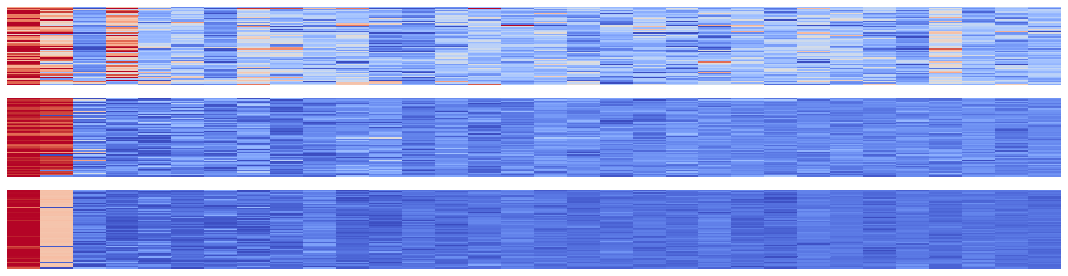

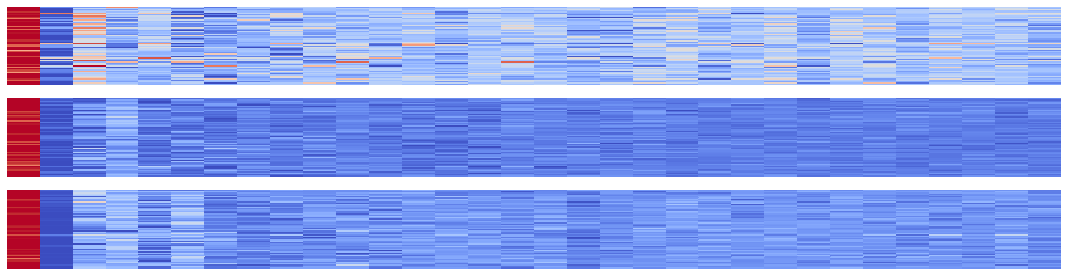

In [19]:
n_x = 32

cols = selected
rows = ['tfidf','glove','scibert']
pad = 5 # in points

# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row.upper(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
for i in range(len(selected)):
#     print(selected[i])
    f, axes = plt.subplots(nrows=3, ncols=1 ,figsize = (15,2*len(selected)))
    for row, method in enumerate(['tfidf','glove','scibert']):
        
        df = pd.DataFrame(models_embeddings[method][samples['label'] == i][sample][:,:n_x])
        sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False, ax=axes[row], robust=True, cmap='coolwarm') 
    f.tight_layout()
    f.savefig(f'Emb_Pattern_Subset_Scibert_{selected[i]}.svg')

In [43]:
# f, axes = plt.subplots(len(selected), 1,figsize = (10,2*len(selected)))
# for i in range(len(selected)):
#     df = pd.DataFrame(models_embeddings['glove'][samples['label'] == i][sample][:,:n_x])
# #     df = df.apply(lambda x: (x-x.mean())/x.std())
#     sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False,ax=axes[i]) # ,cmap='coolwarm',robust=True
#     axes[i].set_ylabel(selected[i],fontsize=14)
# plt.tight_layout()
# # f.savefig('Emb_Pattern_Subset_Glove.png',dpi=300)

In [44]:
# f, axes = plt.subplots(len(selected), 1,figsize = (10,2*len(selected)))
# for i in range(len(selected)):
#     df = pd.DataFrame(models_embeddings['tfidf'][samples['label'] == i][sample][:,:n_x])
# #     df = df.apply(lambda x: (x-x.mean())/x.std())
#     sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False,ax=axes[i]) # ,cmap='coolwarm',robust=True
#     axes[i].set_ylabel(selected[i],fontsize=14)
# plt.tight_layout()
# # f.savefig('Emb_Pattern_Subset_Glove.png',dpi=300)